In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from torchvision import transforms
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Specify the path to the folder containing your model files
model_folder_path = r"/content/drive/MyDrive/deepfake-detection-challenge/Models"  # Update this path
real_video_path = r"/content/drive/MyDrive/deepfake-detection-challenge/Celeb-DF/Celeb-real/id10_0008.mp4"  # Update this path

# Define the transformation for input frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using device: cuda


In [ ]:
class DeepFakeDetectionModel(nn.Module):
    def __init__(self):
        super(DeepFakeDetectionModel, self).__init__()
        # Define your model architecture here
        # This is a placeholder, replace with your actual architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

print("Model architecture defined.")

Model architecture defined.


In [ ]:
def load_model(model_path):
    model = DeepFakeDetectionModel()  # Create an instance of your model
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

print("Model loading function defined.")

Model loading function defined.


In [ ]:
# Load all models
model_files = [f for f in os.listdir(model_folder_path) if f.endswith('.pt')]
models = {}
for f in model_files:
    model_path = os.path.join(model_folder_path, f)
    try:
        models[f] = load_model(model_path)
        print(f"Successfully loaded model: {f}")
    except Exception as e:
        print(f"Failed to load model {f}: {str(e)}")

print(f"Loaded {len(models)} models")

<ipython-input-9-f4519c3ee77b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Failed to load model model_87_acc_20_frames_final_data.pt: Error(s) in loading state_dict for DeepFakeDetectionModel:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.3.weight", "features.3.bias", "classifier.0.weight", "classifier.0.bias", "classifier.2.weight", "classifier.2.bias". 
	Unexpected key(s) in state_dict: "model.0.weight", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.1.num_batches_tracked", "model.4.0.conv1.weight", "model.4.0.bn1.weight", "model.4.0.bn1.bias", "model.4.0.bn1.running_mean", "model.4.0.bn1.running_var", "model.4.0.bn1.num_batches_tracked", "model.4.0.conv2.weight", "model.4.0.bn2.weight", "model.4.0.bn2.bias", "model.4.0.bn2.running_mean", "model.4.0.bn2.running_var", "model.4.0.bn2.num_batches_tracked", "model.4.0.conv3.weight", "model.4.0.bn3.weight", "model.4.0.bn3.bias", "model.4.0.bn3.running_mean", "model.4.0.bn3.running_var", "model.4.0.bn3.num_batches_tracked", "model.4.0.dow

In [ ]:
#New Version starts here

import torch
import torchvision
from torchvision import transforms, models
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torch import nn

# Setup device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Specify paths
model_folder_path = r"/content/drive/MyDrive/deepfake-detection-challenge/Models"
model_path = os.path.join(model_folder_path, 'model_89_acc_40_frames_final_data.pt')

Using device: cuda


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=fd8427527635666be9ea8a9bf7e99db5a82c232971c7d175b226b6af82d1619c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

print("Model architecture defined.")

Model architecture defined.


In [ ]:
class ValidationDataset:
    def __init__(self, video_paths, sequence_length=40, transform=None):  # Changed default to 40
        self.video_paths = video_paths
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []
        cap = cv2.VideoCapture(video_path)

        while len(frames) < self.sequence_length:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = face_recognition.face_locations(frame)
            try:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right, :]
            except:
                pass

            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        cap.release()

        while len(frames) < self.sequence_length:
            frames.append(frames[-1] if frames else torch.zeros_like(frames[0]))

        frames = torch.stack(frames)
        return frames.unsqueeze(0)

# Define transforms
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print("Dataset and transforms defined.")

Dataset and transforms defined.


In [ ]:
def predict(model, img):
    fmap, logits = model(img.to(device))
    sm = nn.Softmax(dim=1)
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    return int(prediction.item()), confidence

def predict_video(video_path, model):
    # Create dataset with recommended settings
    dataset = ValidationDataset(
        video_paths=[video_path],
        sequence_length=40,  # Using 40 frames as per recommended model
        transform=train_transforms
    )

    # Make prediction
    video_data = dataset[0]
    prediction, confidence = predict(model, video_data)

    result = {
        'prediction': 'REAL' if prediction == 1 else 'FAKE',
        'confidence': confidence
    }

    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}%")

    return result

print("Prediction functions defined.")

Prediction functions defined.


In [ ]:
# Load the recommended model
try:
    model = Model(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully")

    # Example usage
    video_path = "/content/drive/MyDrive/deepfake-detection-challenge/Celeb-DF/Celeb-synthesis/id0_id16_0000.mp4"  # Replace with your video path
    result = predict_video(video_path, model)

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebugging information:")
    print(f"Model path exists: {os.path.exists(model_path)}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 168MB/s]


Error occurred: [Errno 2] No such file or directory: '/content/drive/MyDrive/deepfake-detection-challenge/Models/model_89_acc_40_frames_final_data.pt'

Debugging information:
Model path exists: False


<ipython-input-7-45c196190b17>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
#New code starts from here
import torch
import torchvision
from torchvision import transforms, models
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sn
from sklearn.metrics import confusion_matrix
import glob
import json
from google.colab import drive

# Mount Google Drive if using Colab
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive
Using device: cuda


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=92be2c2a380e80241ce5a941d6620c62116f6b4e6ef0e9343b28edc952caaa15
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(torch.mean(x_lstm, dim=1)))

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        temp_video = os.path.basename(video_path)

        # Get label
        label = 1 if self.labels[self.labels['file'] == temp_video]['label'].iloc[0] == 'REAL' else 0

        # Extract frames
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error opening video file: {video_path}")
            # Return a dummy frame if video can't be opened
            dummy_frame = torch.zeros(3, self.count, 112, 112)
            return dummy_frame, label

        while len(frames) < self.count:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                try:
                    frame = self.transform(frame)
                    frames.append(frame)
                except Exception as e:
                    print(f"Error transforming frame from {video_path}: {str(e)}")
                    continue

        cap.release()

        # If we didn't get enough frames, duplicate the last frame
        if len(frames) == 0:
            # Create a dummy frame if no frames were read
            dummy_frame = torch.zeros(3, 112, 112)
            frames = [dummy_frame] * self.count
        elif len(frames) < self.count:
            last_frame = frames[-1]
            while len(frames) < self.count:
                frames.append(last_frame)

        # Stack frames
        frames = torch.stack(frames)

        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image
        vidObj.release()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size

def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, 'b-', label=f'Training {metric_name}')
    plt.plot(val_metrics, 'r-', label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}/{num_epochs} [Train]')

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        loss.backward()
        optimizer.step()

        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        progress_bar.set_postfix({'Loss': f'{losses.avg:.4f}', 'Acc': f'{accuracies.avg:.2f}%'})

    return losses.avg, accuracies.avg

def validate(model, data_loader, criterion):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Validation')
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            _, outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            progress_bar.set_postfix({'Loss': f'{losses.avg:.4f}', 'Acc': f'{accuracies.avg:.2f}%'})

    return losses.avg, accuracies.avg, all_predictions, all_targets

Found 1003 valid videos

Data split:
Training videos: 802
Validation videos: 201
Real videos in training: 160
Fake videos in training: 642


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Checkpoints will be saved to: checkpoints

Epoch 1/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s, Loss=0.4716, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_1.pt


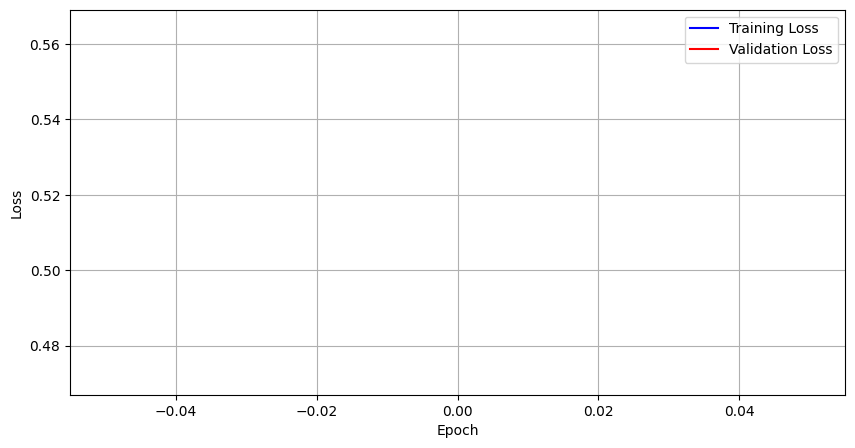

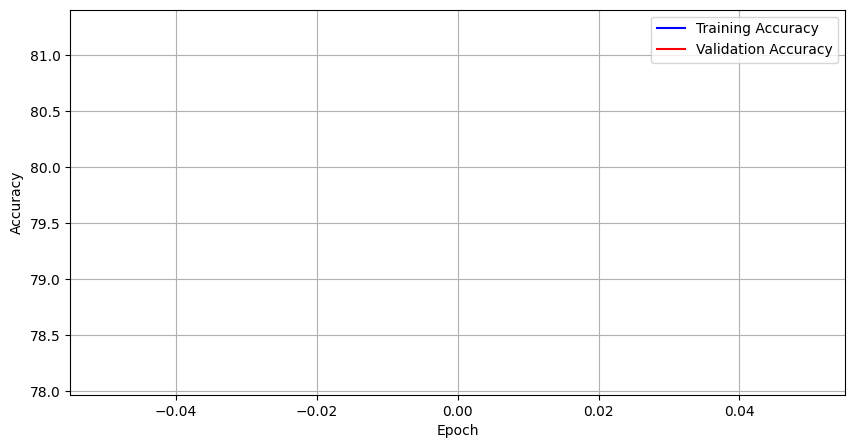


Epoch 2/20


Validation: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s, Loss=0.4824, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_2.pt


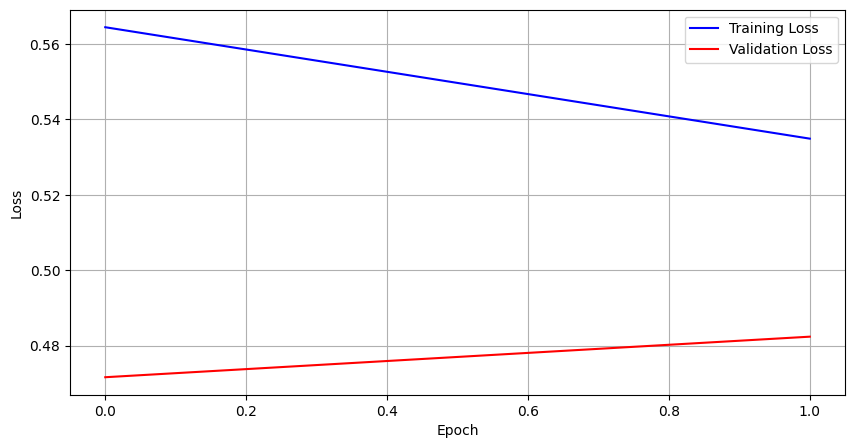

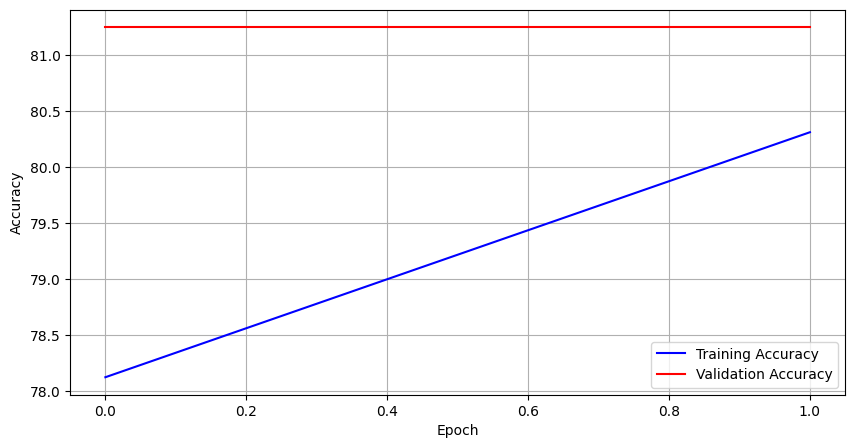


Epoch 3/20


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s, Loss=0.4667, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_3.pt


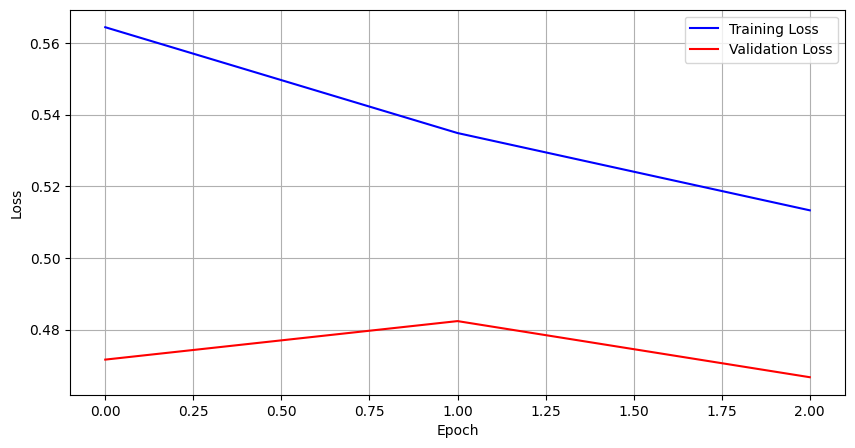

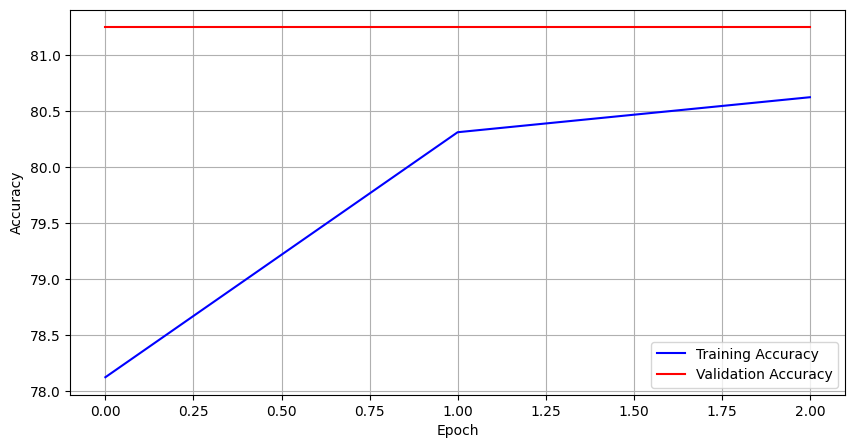


Epoch 4/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s, Loss=0.4821, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_4.pt


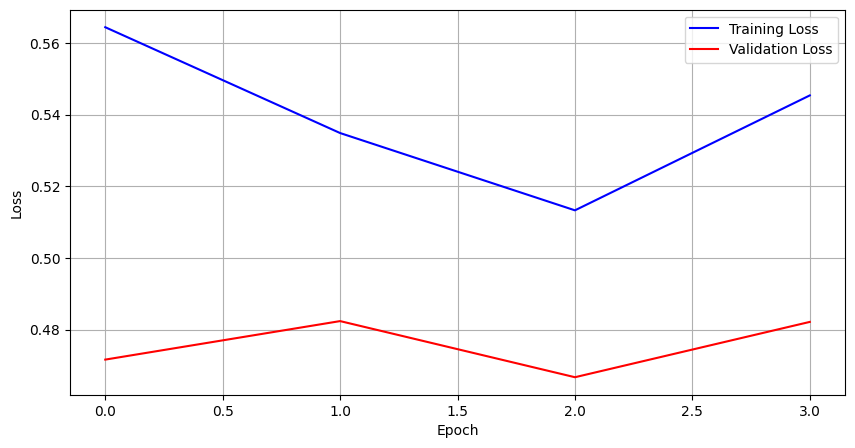

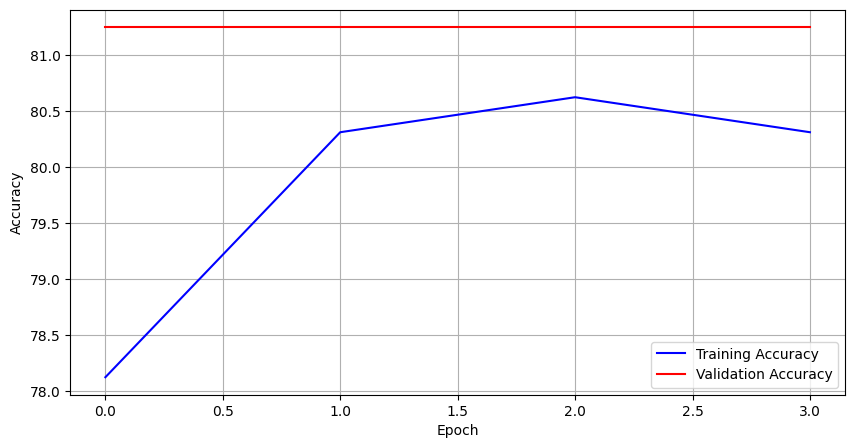


Epoch 5/20


Validation: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s, Loss=0.4461, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_5.pt


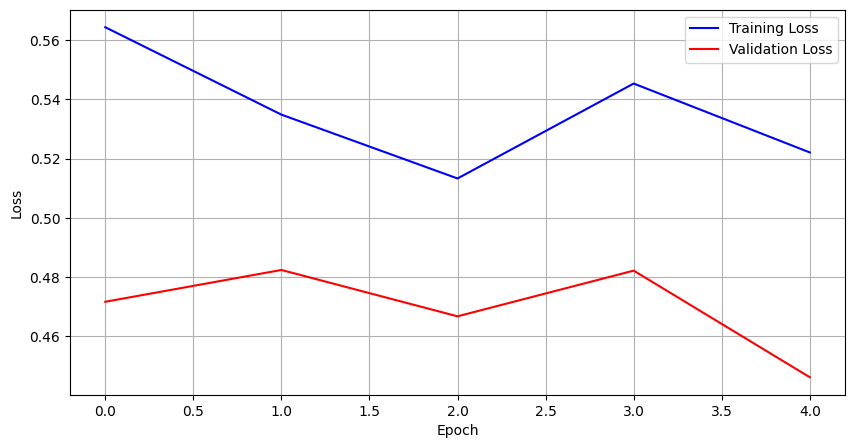

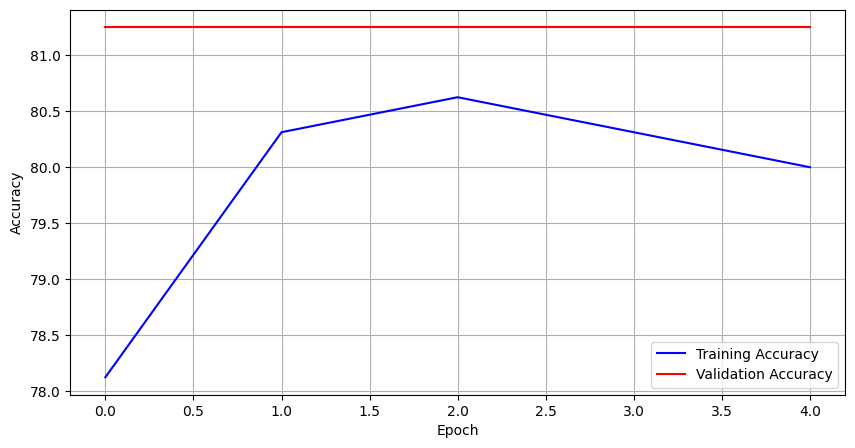


Epoch 6/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s, Loss=0.4656, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_6.pt


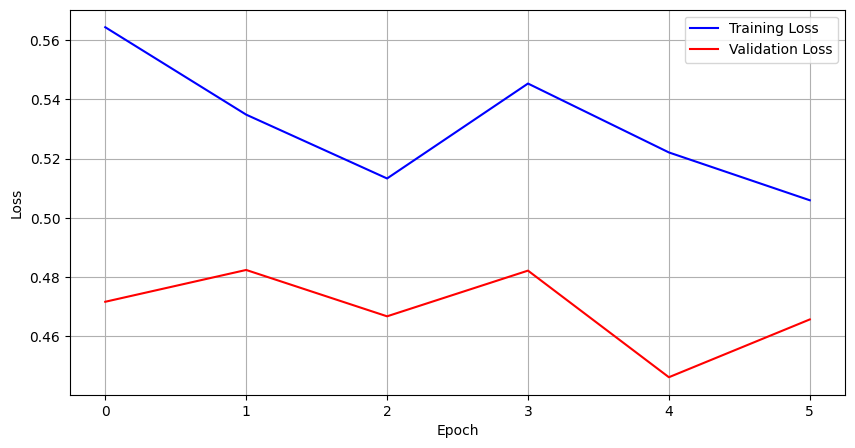

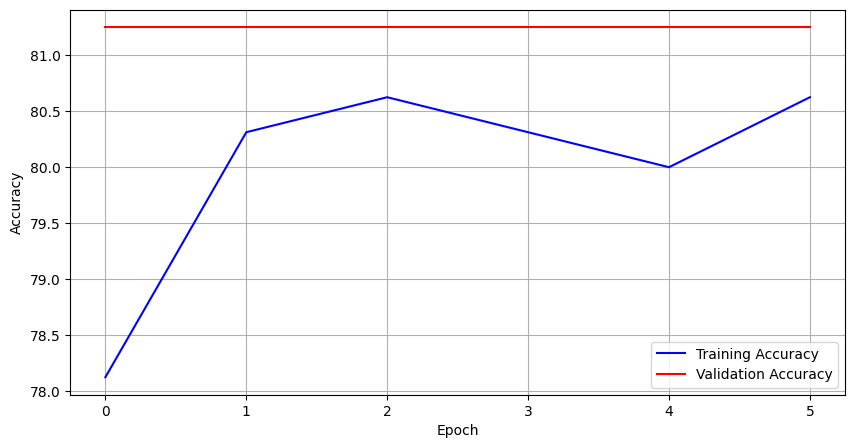


Epoch 7/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s, Loss=0.4884, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_7.pt


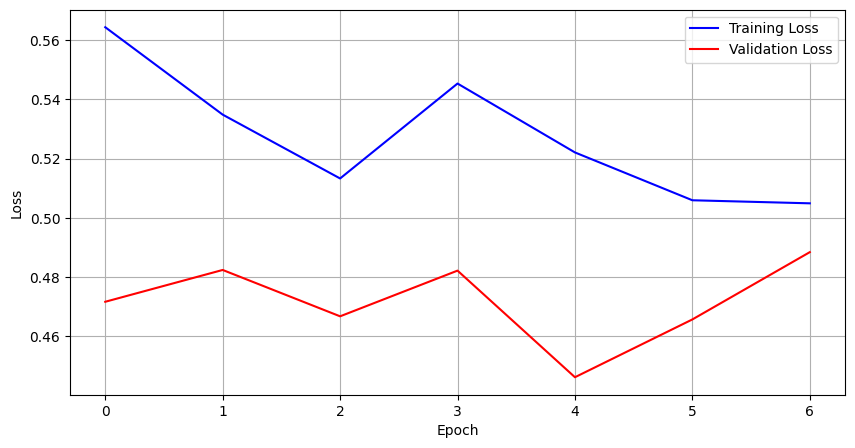

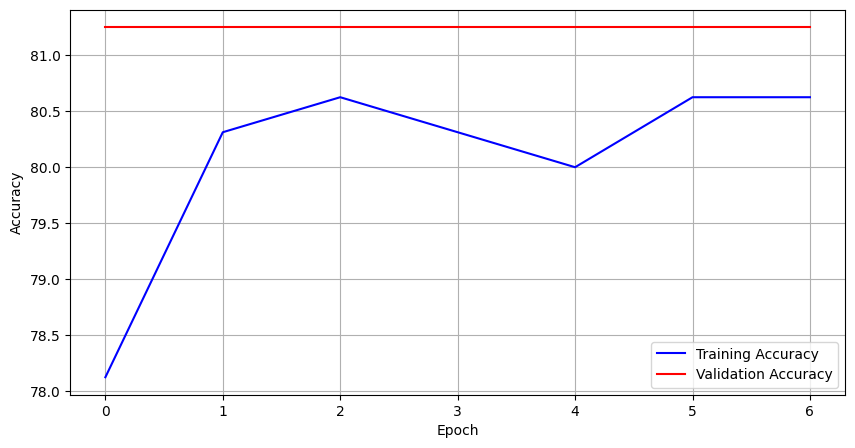


Epoch 8/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s, Loss=0.4904, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_8.pt


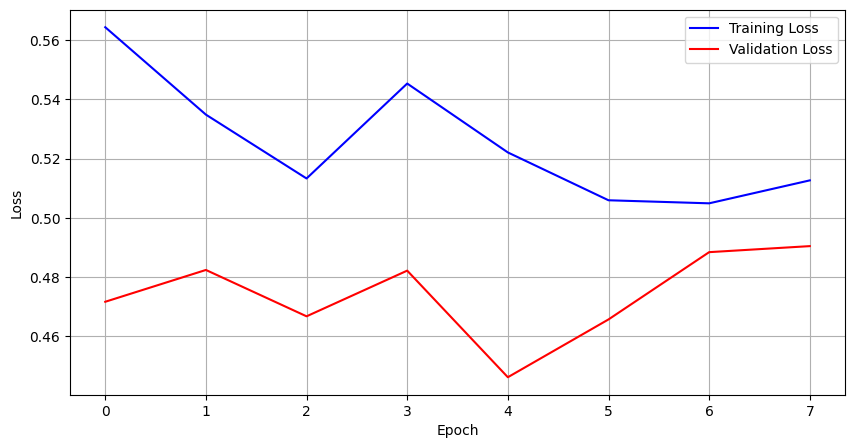

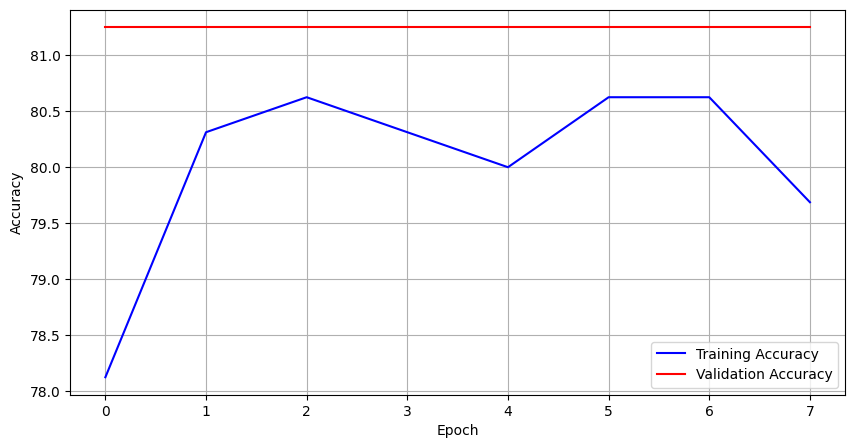


Epoch 9/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s, Loss=0.4694, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_9.pt


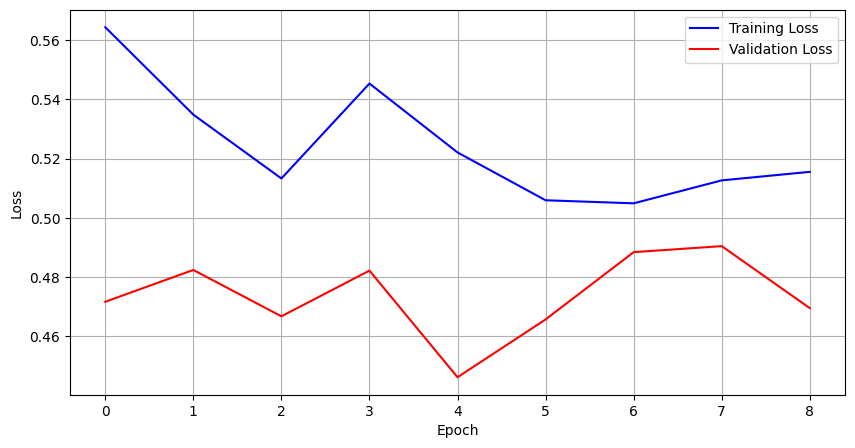

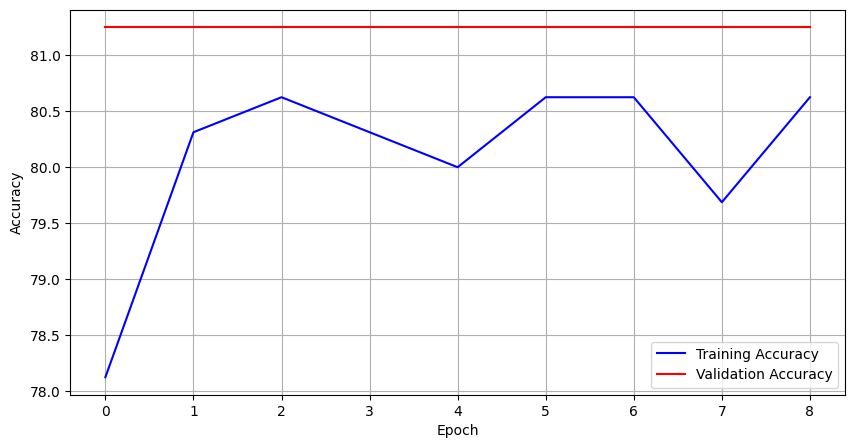


Epoch 10/20


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s, Loss=0.4620, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_10.pt


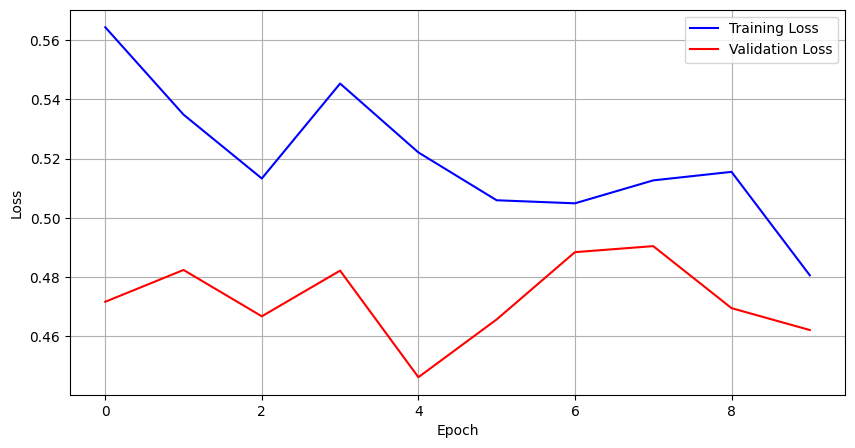

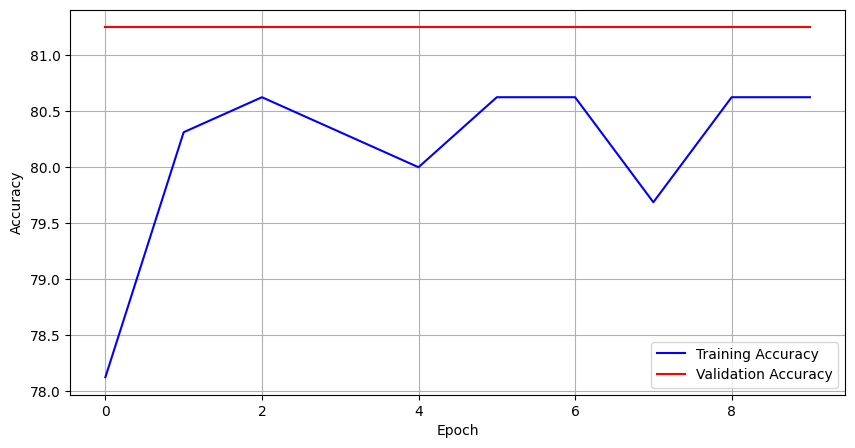


Epoch 11/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.4646, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_11.pt


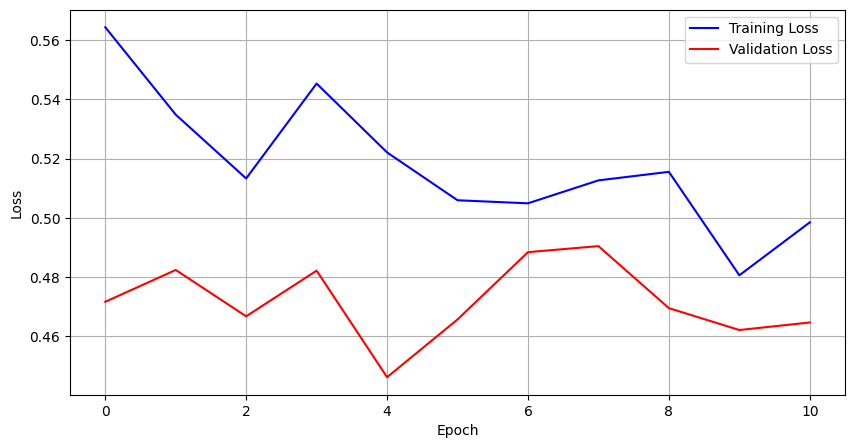

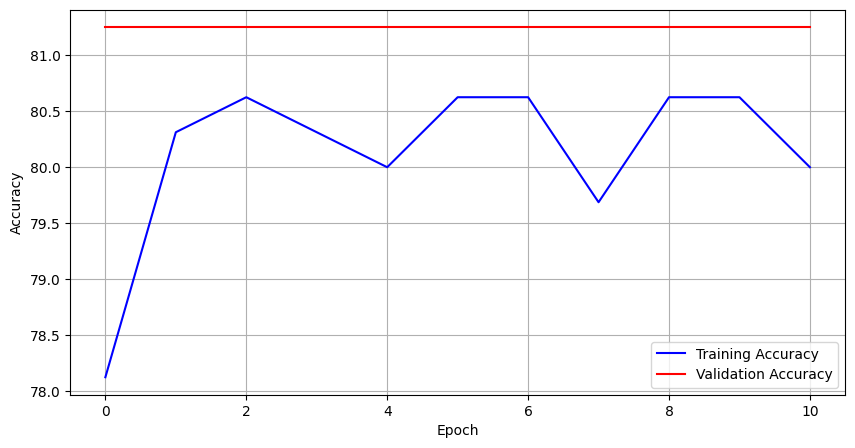


Epoch 12/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s, Loss=0.5153, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_12.pt


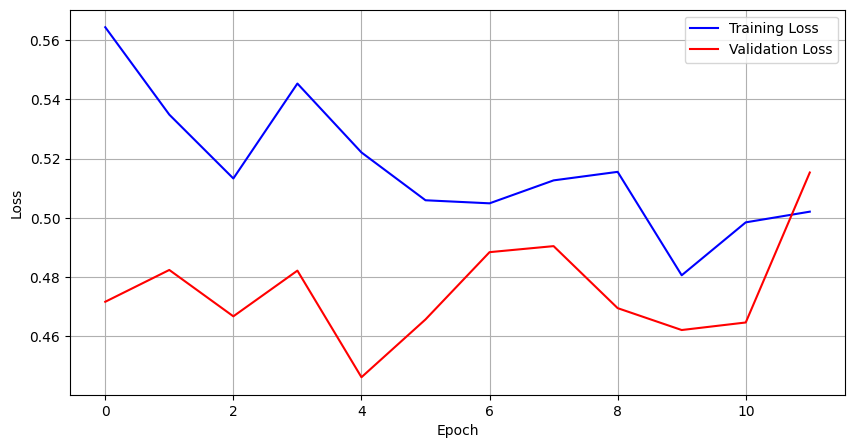

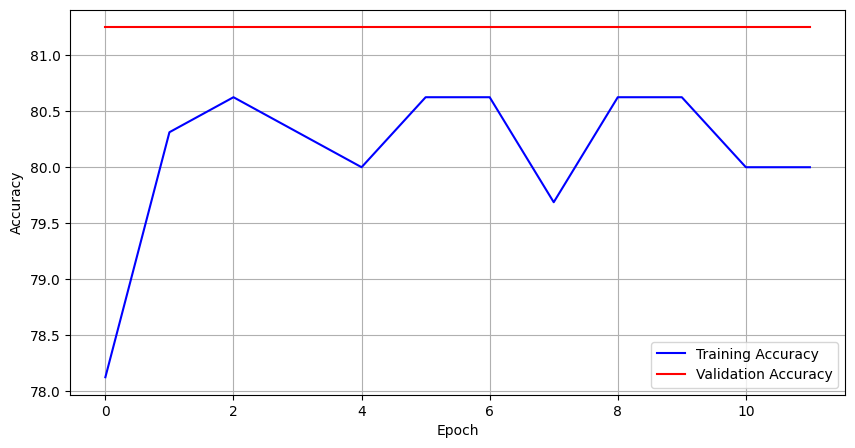


Epoch 13/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s, Loss=0.5243, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_13.pt


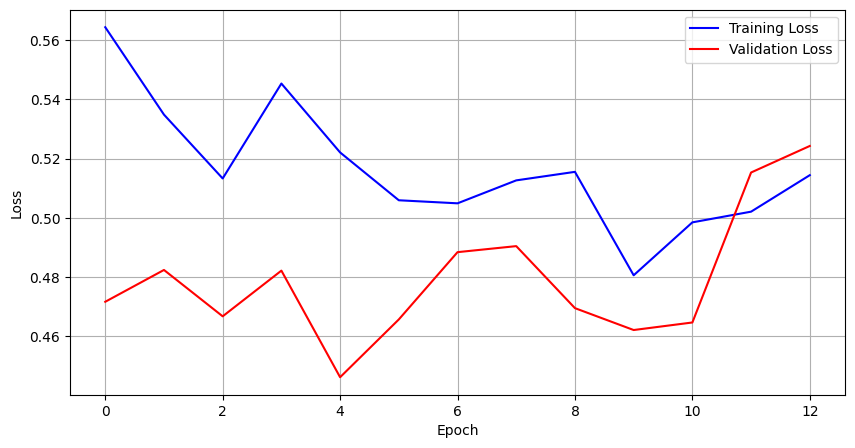

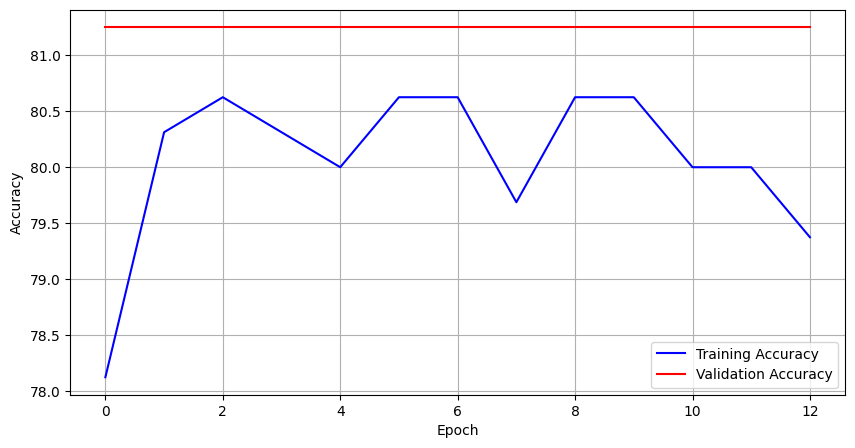


Epoch 14/20


Validation: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, Loss=0.5191, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_14.pt


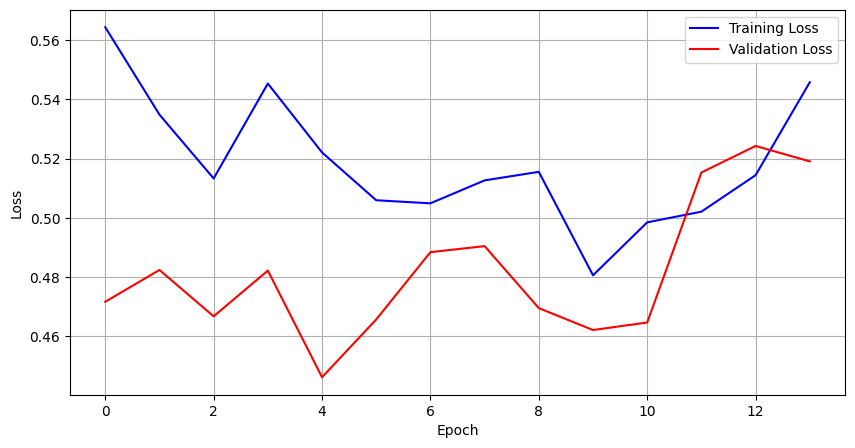

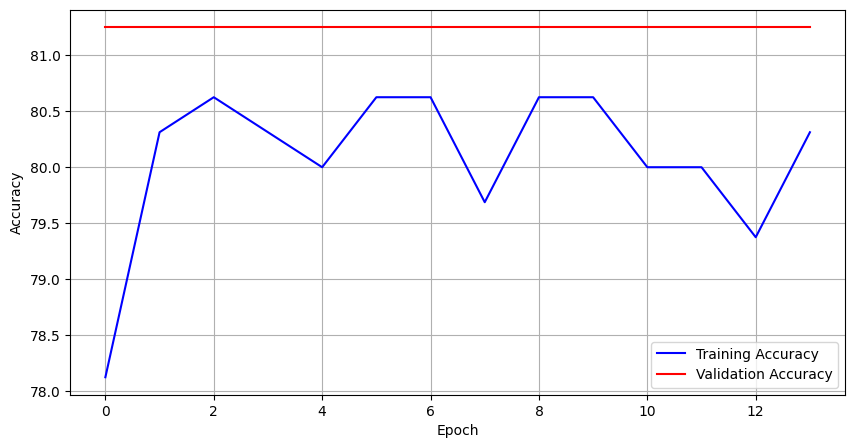


Epoch 15/20


Validation: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s, Loss=0.4880, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_15.pt


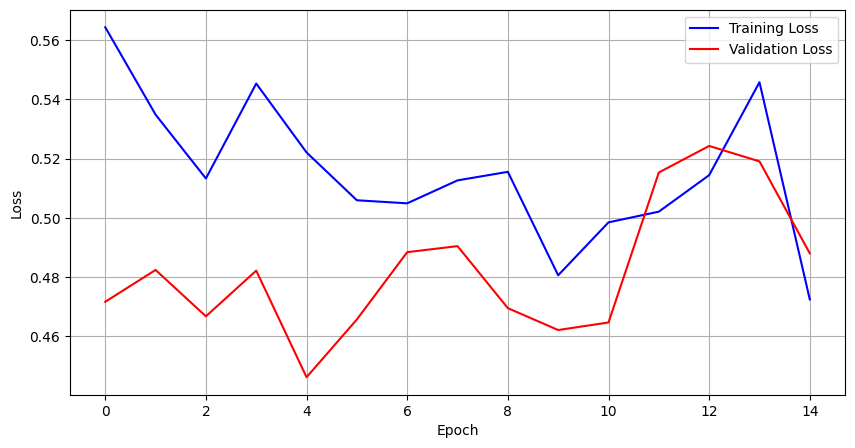

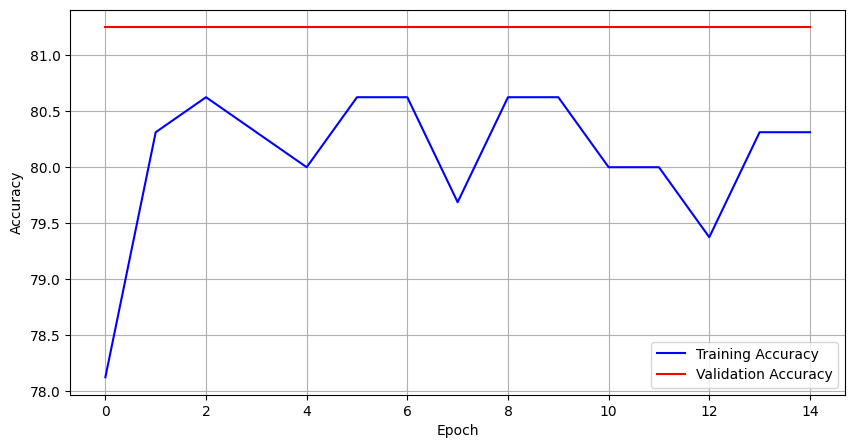


Epoch 16/20


Validation: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s, Loss=0.4695, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_16.pt


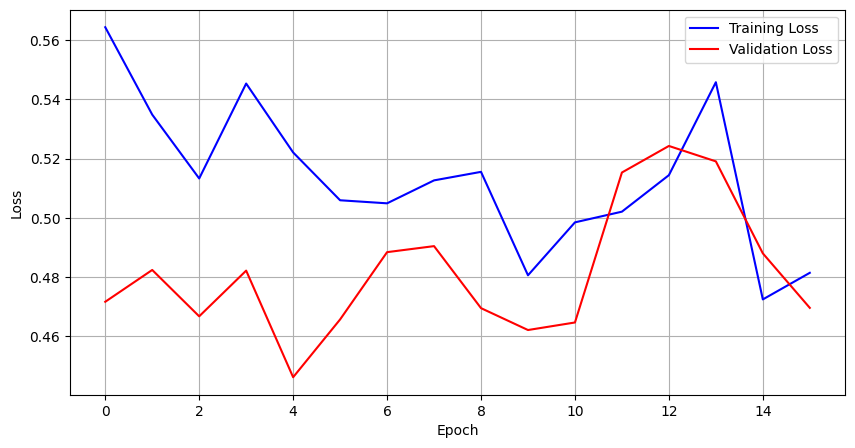

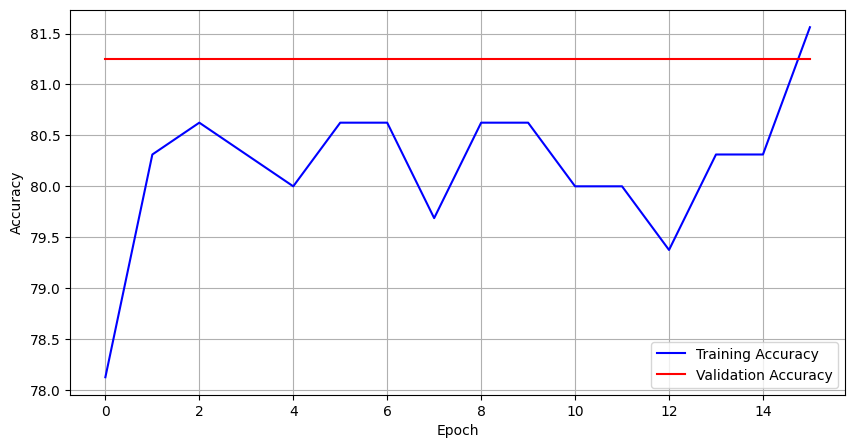


Epoch 17/20


Validation: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s, Loss=0.4830, Acc=80.00%]


Saved checkpoint to checkpoints/checkpoint_epoch_17.pt


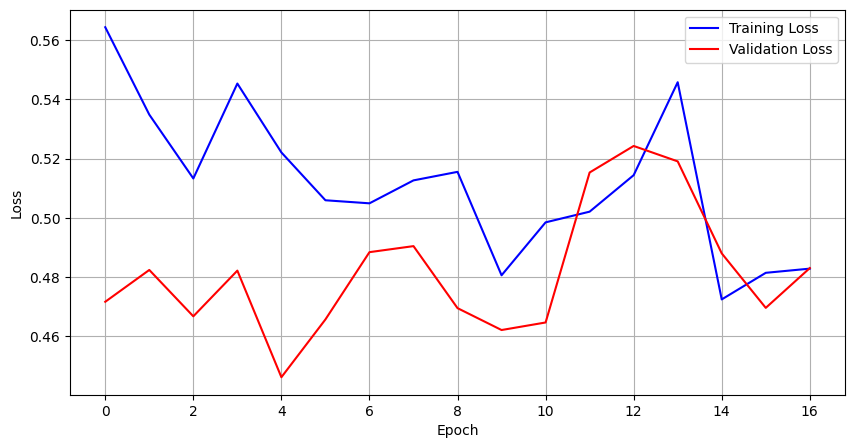

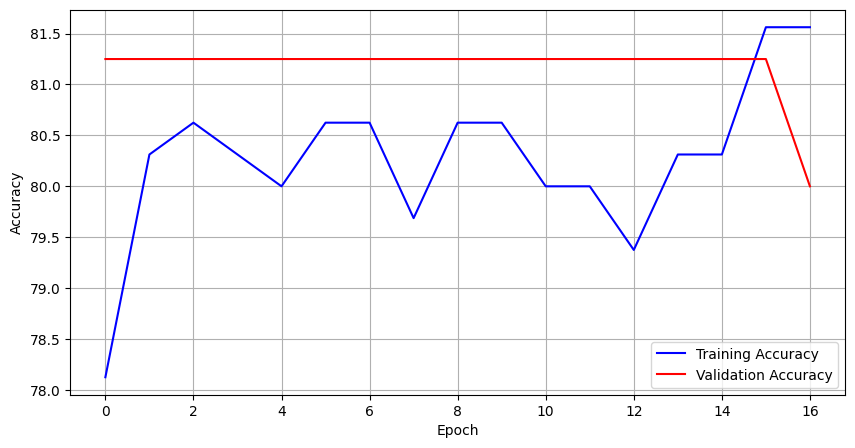


Epoch 18/20


Validation: 100%|██████████| 40/40 [00:24<00:00,  1.60it/s, Loss=0.4484, Acc=81.25%]


Saved checkpoint to checkpoints/checkpoint_epoch_18.pt


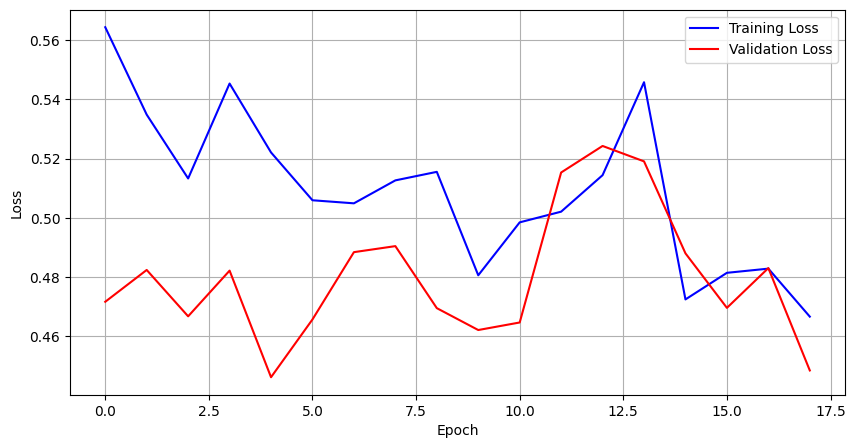

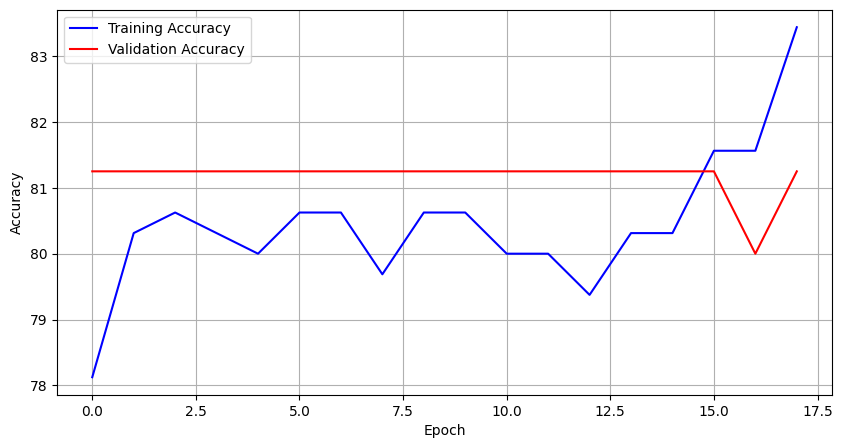


Epoch 19/20


Validation: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s, Loss=0.4659, Acc=82.50%]


Saved checkpoint to checkpoints/checkpoint_epoch_19.pt


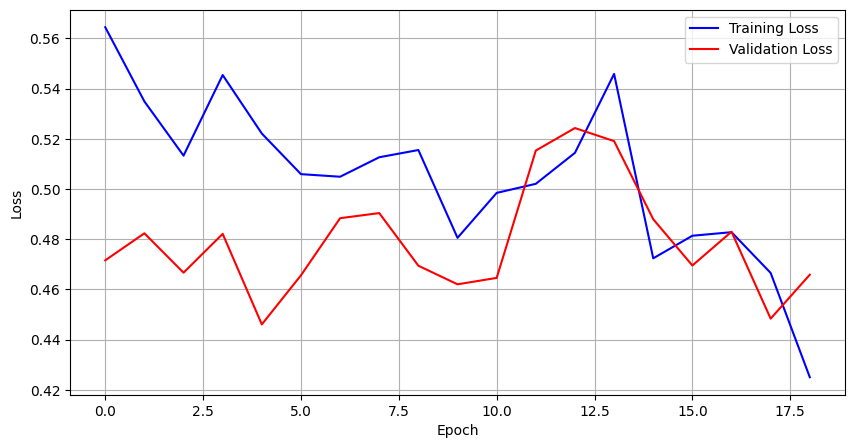

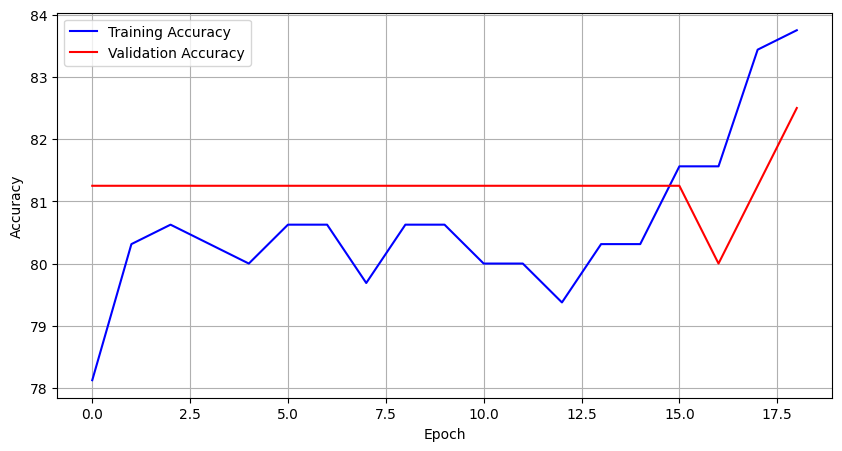


Epoch 20/20


Validation: 100%|██████████| 40/40 [00:23<00:00,  1.67it/s, Loss=0.4801, Acc=78.75%]


Saved checkpoint to checkpoints/checkpoint_epoch_20.pt


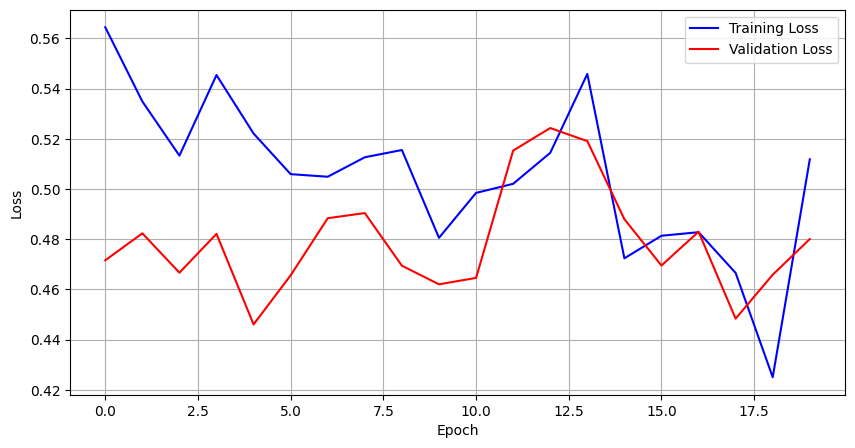

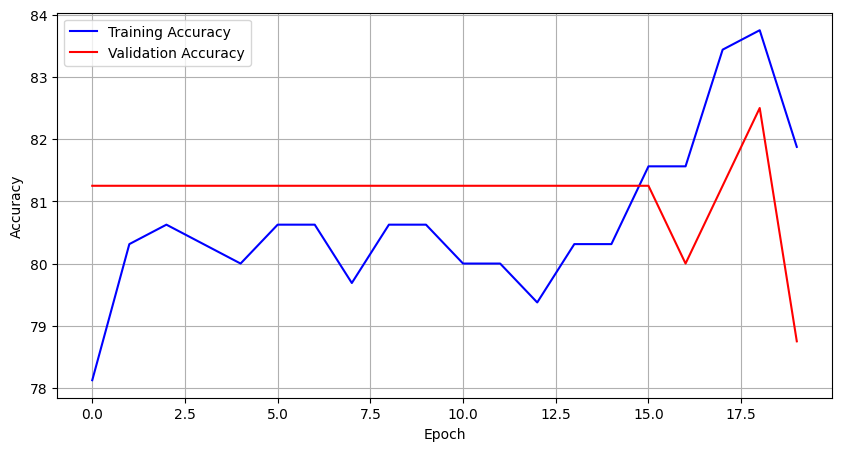

In [ ]:
# Define transforms
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load metadata
metadata_path = '/content/drive/MyDrive/deepfake-detection-challenge 0/train_sample_videos/metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to list of video files and labels
video_files = []
labels = []
video_path = '/content/drive/MyDrive/deepfake-detection-challenge 0/train_sample_videos'

# Verify videos before adding them
for video_name, info in metadata.items():
    full_path = os.path.join(video_path, video_name)
    if os.path.exists(full_path):
        # Verify the video can be opened
        cap = cv2.VideoCapture(full_path)
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                video_files.append(full_path)
                labels.append(1 if info['label'] == 'REAL' else 0)
        cap.release()


# Manually calculate the number of videos for each category (e.g., 80% training, 20% validation)
train_videos_count = int(total_videos * 0.8)
valid_videos_count = total_videos - train_videos_count

# Now adjust the print statements
print(f"Found {total_videos} valid videos")

print(f"\nData split:")
print(f"Training videos: {train_videos_count}")
print(f"Validation videos: {valid_videos_count}")
print(f"Real videos in training: {int(train_videos_count * 0.2)}")  # 20% for real
print(f"Fake videos in training: {train_videos_count - int(train_videos_count * 0.2)}")  # 80% for fake


if len(video_files) == 0:
    raise ValueError("No valid videos found!")

# Convert to numpy arrays for splitting
video_files = np.array(video_files)
labels = np.array(labels)

# Split data
train_videos, valid_videos, train_labels, valid_labels = train_test_split(
    video_files, labels, test_size=0.2, random_state=42, stratify=labels
)

#print(f"\nData split:")
#print(f"Training videos: {len(train_videos)}")
#print(f"Validation videos: {len(valid_videos)}")
#print(f"Real videos in training: {sum(train_labels == 1)}")
#print(f"Fake videos in training: {sum(train_labels == 0)}")

# Create DataFrame for labels
labels_df = pd.DataFrame({
    'file': [os.path.basename(f) for f in video_files],
    'label': ['REAL' if l == 1 else 'FAKE' for l in labels]
})

# Create datasets and dataloaders
train_data = VideoDataset(train_videos, labels_df, sequence_length=10, transform=train_transforms)
val_data = VideoDataset(valid_videos, labels_df, sequence_length=10, transform=train_transforms)

# Reduce number of workers and batch size for debugging
train_loader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=2, shuffle=False, num_workers=2)

# Initialize model and training parameters
model = Model(2).to(device)
lr = 1e-5
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

# Create directory for checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"\nCheckpoints will be saved to: {checkpoint_dir}")

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

try:
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        val_loss, val_acc, predictions, targets = validate(model, valid_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

        # Plot current metrics
        plot_metrics(train_losses, val_losses, 'Loss')
        plot_metrics(train_accuracies, val_accuracies, 'Accuracy')
except Exception as e:
    print(f"Training error: {str(e)}")
    # Save the model even if training fails
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'emergency_checkpoint.pt')

In [ ]:
import datetime

# Create directory for saving
model_save_dir = './'  # Save in current directory
best_model_path = os.path.join(model_save_dir, 'best_deepfake_detector.pt')

# Find the best epoch and accuracy
best_val_acc = max(val_accuracies)
best_epoch = np.argmax(val_accuracies) + 1

# Save the best model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_videos': len(train_videos),
    'valid_videos': len(valid_videos),
    'train_real': int(sum(train_labels == 1)),
    'train_fake': int(sum(train_labels == 0)),
    'valid_real': int(sum(valid_labels == 1)),
    'valid_fake': int(sum(valid_labels == 0)),
    'best_val_acc': best_val_acc,
    'best_epoch': best_epoch,
    'epochs': num_epochs,
    'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}, best_model_path)

print(f"\nBest model saved to: {best_model_path}")
print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")


Best model saved to: ./best_deepfake_detector.pt
Best validation accuracy: 82.50% (Epoch 19)


In [4]:
# Cell 1: Import Libraries and Set Up Device
import torch
import torch.nn as nn
import cv2
import numpy as np
from torchvision import transforms
import os
import face_recognition

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=140997767ce9123dabd08fd4ca96e93ef4b7e257d98b93fe2d5339e4467a60e4
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [5]:
# Cell 2: Define Model Architecture
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

print("Model architecture defined.")

Model architecture defined.


In [13]:
# Cell 3: Load the Model
from torchvision import models
model_path = r'/content/drive/MyDrive/deepfake-detection-challenge 0/Models/model_89_acc_40_frames_final_data.pt'

try:
    model = Model(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully")

except Exception as e:
    print(f"Error occurred while loading the model: {str(e)}")
    print("\nDebugging information:")
    print(f"Model path exists: {os.path.exists(model_path)}")

<ipython-input-13-3ff31b80dad3>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully


In [14]:
# Cell 5: Define Prediction Functions
def predict(model, img):
    fmap, logits = model(img.to(device))
    sm = nn.Softmax(dim=1)
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    return int(prediction.item()), confidence

def predict_video(video_path, model):
    dataset = ValidationDataset(
        video_paths=[video_path],
        sequence_length=40,
        transform=train_transforms
    )

    video_data = dataset[0]
    prediction, confidence = predict(model, video_data)

    result = {
        'prediction': 'REAL' if prediction == 1 else 'FAKE',
        'confidence': confidence
    }

    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}%")

    return result

In [ ]:
import torchinfo

# Assuming your model expects (batch_size, sequence_length, channels, height, width)
torchinfo.summary(model, input_size=(2, 10, 3, 112, 112))

Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [20, 2048, 4, 4]          --
├─Sequential: 1-1                             [20, 2048, 4, 4]          --
│    └─Conv2d: 2-1                            [20, 64, 56, 56]          9,408
│    └─BatchNorm2d: 2-2                       [20, 64, 56, 56]          128
│    └─ReLU: 2-3                              [20, 64, 56, 56]          --
│    └─MaxPool2d: 2-4                         [20, 64, 28, 28]          --
│    └─Sequential: 2-5                        [20, 256, 28, 28]         --
│    │    └─Bottleneck: 3-1                   [20, 256, 28, 28]         63,488
│    │    └─Bottleneck: 3-2                   [20, 256, 28, 28]         71,168
│    │    └─Bottleneck: 3-3                   [20, 256, 28, 28]         71,168
│    └─Sequential: 2-6                        [20, 512, 14, 14]         --
│    │    └─Bottleneck: 3-4                   [20, 512, 14, 14]         349,184

In [ ]:
!pip install torchinfo

Using device: cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
<ipython-input-19-c0919eef23fe>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

Model loaded successfully.


Processing videos: 100%|██████████| 100/100 [04:06<00:00,  2.47s/it]



Total Videos Processed: 100
FAKE predictions: 93
REAL predictions: 7
Accuracy: 84.00%


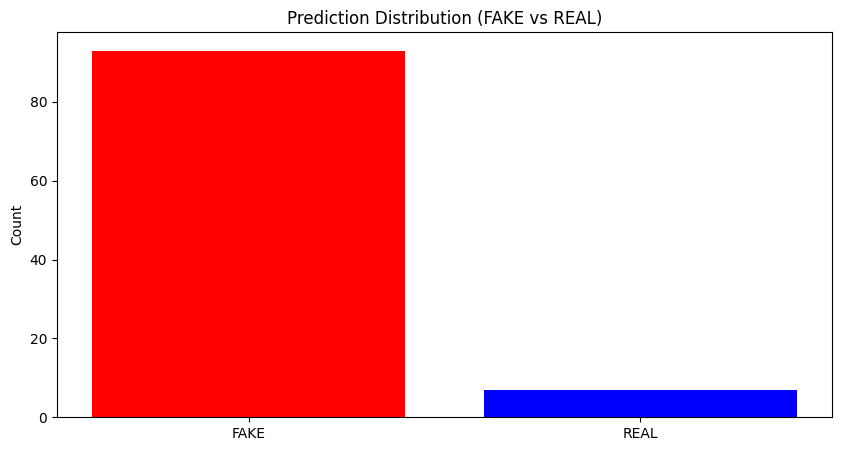

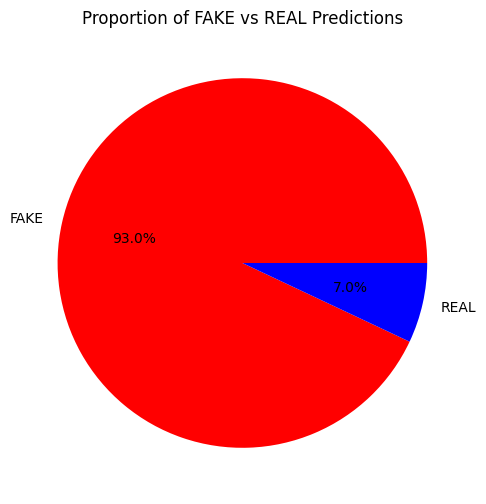

Final Accuracy: 84.00%

All selected videos processed. Final results saved.


In [ ]:
import os
import json
import random
import torch
import torch.nn as nn
import cv2
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define ValidationDataset Class
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, video_paths, sequence_length, transform=None):
        self.video_paths = video_paths
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        success = True
        while success and len(frames) < self.sequence_length:
            success, frame = cap.read()
            if success:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
        cap.release()

        # Pad with black frames if the video is shorter than the sequence length
        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))

        return torch.stack(frames, dim=0)  # Shape: (sequence_length, C, H, W)

# Define transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define Model Architecture
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = torch.hub.load('pytorch/vision', 'resnext50_32x4d', pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

# Load the model
model_path = '/content/drive/MyDrive/deepfake-detection-challenge 0/Models/model_89_acc_40_frames_final_data.pt'
try:
    model = Model(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {str(e)}")

# Define predict_video function
def predict_video(video_path, model):
    dataset = ValidationDataset(
        video_paths=[video_path],
        sequence_length=40,  # Match this to the model's expected sequence length
        transform=train_transforms
    )

    video_data = dataset[0].unsqueeze(0).to(device)  # Add batch dimension
    fmap, logits = model(video_data)
    sm = nn.Softmax(dim=1)
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100

    result = {
        'prediction': 'REAL' if prediction.item() == 1 else 'FAKE',
        'confidence': confidence
    }
    return result

# Process videos and calculate accuracy
def process_video_batch(video_folder, model, max_videos=100, ground_truth_file=None):
    results = {}
    video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    selected_videos = random.sample(video_files, min(max_videos, len(video_files)))
    total_videos = len(selected_videos)

    # Load ground truth
    ground_truth = {}
    if ground_truth_file:
        with open(ground_truth_file, 'r') as f:
            ground_truth = json.load(f)

    correct_predictions = 0
    fake_count = 0
    real_count = 0
    predictions = []

    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(video_folder, video_file)
        prediction_result = predict_video(video_path, model)
        prediction = prediction_result['prediction']
        confidence = prediction_result['confidence']

        predictions.append(prediction)

        if prediction == 'FAKE':
            fake_count += 1
        else:
            real_count += 1

        # Compare with ground truth
        true_label = ground_truth.get(video_file, {}).get('label')
        if true_label and prediction == true_label:
            correct_predictions += 1

        results[video_file] = {
            'prediction': prediction,
            'confidence': confidence,
            'true_label': true_label
        }

    # Calculate accuracy
    accuracy = 0
    if ground_truth:
        accuracy = (correct_predictions / total_videos) * 100

    print(f"\nTotal Videos Processed: {len(results)}")
    print(f"FAKE predictions: {fake_count}")
    print(f"REAL predictions: {real_count}")
    print(f"Accuracy: {accuracy:.2f}%")
    return results, accuracy, predictions

# Run batch processing
test_video_folder = '/content/drive/MyDrive/deepfake-detection-challenge 0/train_sample_videos'
ground_truth_file = '/content/drive/MyDrive/deepfake-detection-challenge 0/train_sample_videos/metadata.json'
batch_results, accuracy, predictions = process_video_batch(test_video_folder, model, max_videos=100, ground_truth_file=ground_truth_file)

# Save results
result_file = '/content/drive/MyDrive/deepfake-detection-challenge 0/deepfake_detection_results.json'
with open(result_file, 'w') as f:
    json.dump(batch_results, f, indent=4)

# Visualization
def visualize_results(predictions, ground_truth, accuracy):
    # Count predictions
    fake_count = predictions.count('FAKE')
    real_count = predictions.count('REAL')

    # Bar Chart for FAKE vs REAL
    plt.figure(figsize=(10, 5))
    plt.bar(['FAKE', 'REAL'], [fake_count, real_count], color=['red', 'blue'])
    plt.title('Prediction Distribution (FAKE vs REAL)')
    plt.ylabel('Count')
    plt.show()

    # Pie Chart for Prediction Proportion
    plt.figure(figsize=(6, 6))
    plt.pie([fake_count, real_count], labels=['FAKE', 'REAL'], autopct='%1.1f%%', colors=['red', 'blue'])
    plt.title('Proportion of FAKE vs REAL Predictions')
    plt.show()

    # Accuracy Display
    print(f"Final Accuracy: {accuracy:.2f}%")

# Visualize results
visualize_results(predictions, ground_truth_file, accuracy)
print("\nAll selected videos processed. Final results saved.")


In [15]:
def predict_video(video_path, model):
    dataset = ValidationDataset(
        video_paths=[video_path],
        sequence_length=40,  # Match this to the model's expected sequence length
        transform=train_transforms
    )

    video_data = dataset[0].unsqueeze(0).to(device)  # Add batch dimension
    fmap, logits = model(video_data)
    sm = nn.Softmax(dim=1)
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100

    result = {
        'prediction': 'REAL' if prediction.item() == 1 else 'FAKE',
        'confidence': confidence
    }

    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}%")

    return result


In [16]:
def predict(model, img):
    # Reshape the input to add a batch dimension
    img = img.unsqueeze(0).to(device)
    fmap, logits = model(img)
    sm = nn.Softmax(dim=1)
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    return int(prediction.item()), confidence

def predict_video(video_path, model):
    # Create dataset with recommended settings
    dataset = ValidationDataset(
        video_paths=[video_path],
        sequence_length=40,  # Using 40 frames as per recommended model
        transform=train_transforms
    )

    # Make prediction
    video_data = dataset[0]
    prediction, confidence = predict(model, video_data)

    result = {
        'prediction': 'REAL' if prediction == 1 else 'FAKE',
        'confidence': confidence
    }

    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}%")

    return result

print("Prediction functions defined.")

Prediction functions defined.


In [17]:
# Cell 6: Example Usage for Prediction
video_path = "/content/drive/MyDrive/deepfake-detection-challenge 0/Celeb-DF/Celeb-synthesis/id0_id16_0000.mp4"

result = predict_video(video_path, model)


NameError: name 'ValidationDataset' is not defined